In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec_v5/other/default/1/model_ug_cbow.word2vec
/kaggle/input/word2vec_v5/other/default/1/model_ug_sg.word2vec
/kaggle/input/uit-dataset/UIT-VSFC_dev.csv
/kaggle/input/uit-dataset/UIT-VSFC_test.csv
/kaggle/input/uit-dataset/UIT-VSFC_train.csv
/kaggle/input/uit-vsfc-tao-sinh-balanced/UIT-VSFC_train_tao_sinh_balanced.csv
/kaggle/input/word2vec_v4/other/default/1/model_ug_cbow.word2vec
/kaggle/input/word2vec_v4/other/default/1/model_ug_sg.word2vec
/kaggle/input/word2vec/other/default/1/word2vec_train_on_review_dataset.model
/kaggle/input/word2vec_v11/other/default/1/model_ug_cbow.word2vec
/kaggle/input/word2vec_v11/other/default/1/model_ug_sg.word2vec
/kaggle/input/stopwords-small/stopwords-vi_news.txt
/kaggle/input/stopwords-small-v3/stopwords-vi_news.txt
/kaggle/input/word2vec_v2/other/default/1/word2vec_ug_sg.word2vec
/kaggle/input/word2vec_v2/other/default/1/word2vec_ug_cbow.word2vec
/kaggle/input/uit-vsfc-train-balance/UIT-VSFC_train_undersampling_10.csv
/kaggle/inpu

In [2]:
!pip install pyvi
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 64.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 31.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from keras.layers import Dense
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from pyvi import ViTokenizer
from pyvi import ViUtils

In [4]:
train_data = pd.read_csv('/kaggle/input/29012025-1/UIT-VSFC_train_cleaned_simple.csv')
dev_data = pd.read_csv('/kaggle/input/29012025-1/UIT-VSFC_dev_cleaned_simple.csv')
test_data = pd.read_csv('/kaggle/input/29012025-1/UIT-VSFC_test_cleaned_simple.csv')
train_data_tao_sinh = pd.read_csv('/kaggle/input/uit-vsfc-tao-sinh-balanced/UIT-VSFC_train_tao_sinh_balanced.csv')

In [5]:
train_data = train_data.dropna()
test_data = test_data.dropna()
dev_data = dev_data.dropna()
train_data_tao_sinh = train_data_tao_sinh.dropna()

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11422 entries, 0 to 11421
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sents       11422 non-null  object 
 1   sentiments  11422 non-null  float64
 2   tokens      11422 non-null  object 
dtypes: float64(1), object(2)
memory usage: 267.8+ KB


In [7]:
train_data_tao_sinh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52692 entries, 0 to 52691
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sents       52692 non-null  object 
 1   sentiments  52692 non-null  float64
 2   tokens      52692 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [8]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sents       1583 non-null   object 
 1   sentiments  1583 non-null   float64
 2   tokens      1583 non-null   object 
dtypes: float64(1), object(2)
memory usage: 37.2+ KB


In [9]:
test_data.info()
y_test_1d = test_data.drop(test_data.columns[[0]],axis=1)
y_test_1d = y_test_1d.values.tolist()
y_test_1d = np.array(y_test_1d).flatten()
print(y_test_1d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sents       3166 non-null   object 
 1   sentiments  3166 non-null   float64
 2   tokens      3166 non-null   object 
dtypes: float64(1), object(2)
memory usage: 74.3+ KB
['2.0' "['nói', 'tiếng', 'anh', 'lưu loát']" '2.0' ...
 "['tiếp thu', 'chậm']" '1.0'
 "['có', 'học', 'ở', 'trung tâm', 'tiếng', 'anh', 'ở', 'ngoài', 'trường', 'thời lượng', 'hợp lý', 'không', 'nhiều', 'không', 'ít', 'khoảng', 'tiết', 'buổi']"]


In [10]:
train_data.head()

,sents,sentiments,tokens
0,tài liệu tài liệu đầy đủ,2.0,"['tài liệu', 'tài liệu', 'đầy đủ']"
1,nhiệt tình giảng dạy gần gũi,2.0,"['nhiệt tình', 'giảng dạy', 'gần gũi']"
2,đi học đầy đủ điểm chuyên cần,0.0,"['đi', 'học', 'đầy đủ', 'điểm', 'chuyên', 'cần']"
3,chưa áp dụng công nghệ thông tin các thiết bị ...,0.0,"['chưa', 'áp dụng', 'công nghệ thông tin', 'cá..."
4,giảng bài hay có nhiều bài tập ví dụ ngay trên...,2.0,"['giảng', 'bài', 'hay', 'có', 'nhiều', 'bài tậ..."


In [11]:
train_data_tao_sinh.info()
y_train_tao_sinh_1d = train_data_tao_sinh.drop(train_data_tao_sinh.columns[[0, 2]],axis=1)
y_train_tao_sinh_1d = y_train_tao_sinh_1d.values.tolist()
y_train_tao_sinh_1d = np.array(y_train_tao_sinh_1d).flatten()
print(y_train_tao_sinh_1d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52692 entries, 0 to 52691
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sents       52692 non-null  object 
 1   sentiments  52692 non-null  float64
 2   tokens      52692 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB
[2. 0. 1. ... 0. 1. 1.]


In [12]:
train_data.info()
y_train_1d = train_data.drop(train_data.columns[[0]],axis=1)
y_train_1d = y_train_1d.values.tolist()
y_train_1d = np.array(y_train_1d).flatten()
print(y_train_1d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11422 entries, 0 to 11421
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sents       11422 non-null  object 
 1   sentiments  11422 non-null  float64
 2   tokens      11422 non-null  object 
dtypes: float64(1), object(2)
memory usage: 267.8+ KB
['2.0' "['tài liệu', 'tài liệu', 'đầy đủ']" '2.0' ...
 "['dạy', 'dễ', 'hiểu', 'nhiệt tình']" '2.0'
 "['gói', 'gọn', 'hay', 'tận tình', 'phù hợp', 'mọi', 'trình độ', 'cũng', 'nhu cầu', 'môn học']"]


In [13]:
import numpy as np

# Kết hợp dữ liệu
# data_full = pd.concat([train_data, dev_data, test_data], ignore_index=True)

# Tự động chuyển giá trị không hợp lệ thành NaN
train_data.iloc[:, 1] = pd.to_numeric(train_data.iloc[:, 1], errors='coerce')

# Loại bỏ các hàng chứa NaN trong cả data_full
train_data = train_data.dropna(subset=[train_data.columns[1]])

# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_train = train_data.iloc[:, 1].astype(int).to_numpy()

print(label_idx_train)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_train = tf_keras.utils.to_categorical(label_idx_train, num_classes=3, dtype='float32')

[2 2 0 ... 0 2 2]


In [14]:
import numpy as np

# Kết hợp dữ liệu
# data_full = pd.concat([train_data, dev_data, test_data], ignore_index=True)

# Tự động chuyển giá trị không hợp lệ thành NaN
train_data_tao_sinh.iloc[:, 1] = pd.to_numeric(train_data_tao_sinh.iloc[:, 1], errors='coerce')

# Loại bỏ các hàng chứa NaN trong cả data_full
train_data_tao_sinh = train_data_tao_sinh.dropna(subset=[train_data_tao_sinh.columns[1]])

# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_train_tao_sinh = train_data_tao_sinh.iloc[:, 1].astype(int).to_numpy()

print(label_idx_train_tao_sinh)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_train_tao_sinh = tf_keras.utils.to_categorical(label_idx_train_tao_sinh, num_classes=3, dtype='float32')

[2 0 1 ... 0 1 1]


In [15]:
import numpy as np

# Kết hợp dữ liệu
# data_full = pd.concat([train_data, dev_data, test_data], ignore_index=True)

# Tự động chuyển giá trị không hợp lệ thành NaN
test_data.iloc[:, 1] = pd.to_numeric(test_data.iloc[:, 1], errors='coerce')

# Loại bỏ các hàng chứa NaN trong cả data_full
test_data = test_data.dropna(subset=[test_data.columns[1]])

# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_test = test_data.iloc[:, 1].astype(int).to_numpy()

print(label_idx_test)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_test = tf_keras.utils.to_categorical(label_idx_test, num_classes=3, dtype='float32')

[2 2 2 ... 2 0 1]


In [16]:
import numpy as np

# Kết hợp dữ liệu
# data_full = pd.concat([train_data, dev_data, test_data], ignore_index=True)

# Tự động chuyển giá trị không hợp lệ thành NaN
dev_data.iloc[:, 1] = pd.to_numeric(dev_data.iloc[:, 1], errors='coerce')

# Loại bỏ các hàng chứa NaN trong cả data_full
dev_data = dev_data.dropna(subset=[dev_data.columns[1]])

# Chuyển cột cuối cùng thành kiểu số nguyên và mảng 1 chiều
label_idx_dev = dev_data.iloc[:, 1].astype(int).to_numpy()

print(label_idx_dev)

# Chuyển đổi nhãn thành định dạng one-hot encoding
label_tf_dev = tf_keras.utils.to_categorical(label_idx_dev, num_classes=3, dtype='float32')

[0 0 2 ... 0 0 0]


In [17]:
print(dev_data)

                                                  sents  sentiments  \
0                                  tài liệu chưa cụ thể         0.0   
1                                        giảng buồn ngủ         0.0   
2                                      vui tính tận tâm         2.0   
3     nên giao bài tập nhiều hơn chia nhóm làm bài t...         0.0   
4     cần giảng bài chi tiết hơn đi sâu hơn chạy thử...         0.0   
...                                                 ...         ...   
1578                                hướng dẫn lab mơ hồ         0.0   
1579  những bài tập mang tính thực hành thực tiễn ca...         2.0   
1580                không dạy nhiều chủ yếu tự tìm hiểu         0.0   
1581  muốn đổi tên môn học tên môn lập trình học thi...         0.0   
1582  vừa dạy vừa trò chuyện hoặc gọi điện thoại thư...         0.0   

                                                 tokens  
0                        ['tài liệu', 'chưa', 'cụ thể']  
1                              

In [18]:
y_train = label_tf_train
y_dev = label_tf_dev
y_test = label_tf_test
y_train_tao_sinh = label_tf_train_tao_sinh

print("y_train shape:", y_train.shape)
print("y_train_tao_sinh shape:", y_train_tao_sinh.shape)
print("y_val shape:", y_dev.shape)
print("y_test shape:", y_test.shape)

y_train shape: (11422, 3)
y_train_tao_sinh shape: (52692, 3)
y_val shape: (1583, 3)
y_test shape: (3166, 3)


In [19]:
train_data_text = train_data.sents
test_data_text = test_data.sents
dev_data_text = dev_data.sents
train_data_text_tao_sinh = train_data_tao_sinh.sents

In [20]:
train_data_text = train_data_text.values.tolist()
test_data_text = test_data_text.values.tolist()
dev_data_text = dev_data_text.values.tolist()
train_data_text_tao_sinh = train_data_text_tao_sinh.values.tolist()

In [21]:
import numpy as np
import ast  # Để chuyển đổi chuỗi về danh sách Python

# Chuyển đổi từ chuỗi danh sách (nếu cần)
train_data_tokens = train_data.tokens.apply(ast.literal_eval)
test_data_tokens = test_data.tokens.apply(ast.literal_eval)
dev_data_tokens = dev_data.tokens.apply(ast.literal_eval)

# Biến đổi về danh sách phẳng
train_data_tokens = [token for sublist in train_data_tokens for token in sublist]
test_data_tokens = [token for sublist in test_data_tokens for token in sublist]
dev_data_tokens = [token for sublist in dev_data_tokens for token in sublist]

# Chuyển đổi thành NumPy array nếu cần
train_data_tokens = np.array(train_data_tokens)
test_data_tokens = np.array(test_data_tokens)
dev_data_tokens = np.array(dev_data_tokens)

# In ra để kiểm tra
print(dev_data_tokens)


['tài liệu' 'chưa' 'cụ thể' ... 'gọi' 'điện thoại' 'thường xuyên']


In [22]:
print(train_data_tokens)

['tài liệu' 'tài liệu' 'đầy đủ' ... 'cũng' 'nhu cầu' 'môn học']


In [23]:
print("Sample train_data_tokens:", train_data_tokens[:5])
print("Sample train_data_text:", train_data_text[:5])

Sample train_data_tokens: ['tài liệu' 'tài liệu' 'đầy đủ' 'nhiệt tình' 'giảng dạy']
Sample train_data_text: ['tài liệu tài liệu đầy đủ', 'nhiệt tình giảng dạy gần gũi', 'đi học đầy đủ điểm chuyên cần', 'chưa áp dụng công nghệ thông tin các thiết bị hỗ trợ việc giảng dạy', 'giảng bài hay có nhiều bài tập ví dụ ngay trên lớp']


In [24]:
 pip install emot --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
# import string
# import regex as re
# import numpy as np
# import pandas as pd
# from underthesea import word_tokenize, text_normalize

# # =======================
# # Vietnamese Character Normalization Functions
# # =======================

# # Define Unicode and Unsigned Characters
# uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
# unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

# def loaddicchar():
#     """
#     Load a dictionary mapping accented Vietnamese characters to their base forms.
#     """
#     dic = {}
#     # Define the list of accented characters (1252 encoding)
#     char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|' \
#               'ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|' \
#               'ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|' \
#               'À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|' \
#               'È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|' \
#               'Ì|Í|Ỉ|Ĩ|Ị|' \
#               'Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|' \
#               'Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|' \
#               'Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')

#     # Define the list of UTF-8 encoded characters
#     charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|" \
#               "ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|" \
#               "ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|" \
#               "À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|" \
#               "È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|" \
#               "Ì|Í|Ỉ|Ĩ|Ị|" \
#               "Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|" \
#               "Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|" \
#               "Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')

#     # Create the dictionary mapping
#     for i in range(len(char1252)):
#         dic[char1252[i]] = charutf8[i]
#     return dic

# dicchar = loaddicchar()

# def covert_unicode(txt):
#     """
#     Convert accented Vietnamese characters to their base forms.
#     """
#     return re.sub(
#         r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|' \
#         r'è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|' \
#         r'ì|í|ỉ|ĩ|ị|' \
#         r'ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|' \
#         r'ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|' \
#         r'ỳ|ý|ỷ|ỹ|ỵ|' \
#         r'À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|' \
#         r'È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|' \
#         r'Ì|Í|Ỉ|Ĩ|Ị|' \
#         r'Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|' \
#         r'Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|' \
#         r'Ỳ|Ý|Ỷ|Ỹ|Ỵ',
#         lambda x: dicchar[x.group()], txt)

# # =======================
# # Existing Vietnamese Accent Normalization Functions
# # =======================

# # Define mappings for Vietnamese vowels and their accents
# # Note: Ensure that bang_nguyen_am and nguyen_am_to_ids are fully defined
# bang_nguyen_am = [
#     ['a', 'à', 'á', 'ả', 'ã', 'ạ'],
#     ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ'],
#     ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ'],
#     ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ'],
#     ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ'],
#     ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị'],
#     ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ'],
#     ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ'],
#     ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ'],
#     ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ'],
#     ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự'],
#     ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ'],
#     # Add more vowels if necessary
# ]

# # Create a mapping from vowel to its indices in bang_nguyen_am
# nguyen_am_to_ids = {}
# for idx, vowel_group in enumerate(bang_nguyen_am):
#     for jdx, vowel in enumerate(vowel_group):
#         nguyen_am_to_ids[vowel] = (idx, jdx)

# def is_valid_vietnam_word(word):
#     chars = list(word)
#     nguyen_am_index = -1
#     for index, char in enumerate(chars):
#         x, y = nguyen_am_to_ids.get(char, (-1, -1))
#         if x != -1:
#             if nguyen_am_index == -1:
#                 nguyen_am_index = index
#             else:
#                 if index - nguyen_am_index != 1:
#                     return False
#                 nguyen_am_index = index
#     return True

# def chuan_hoa_dau_tieng_viet(word):
#     if not is_valid_vietnam_word(word):
#         return word
#     chars = list(word)
#     dau_cau = 0
#     nguyen_am_index = []
#     qu_or_gi = False
#     for index, char in enumerate(chars):
#         x, y = nguyen_am_to_ids.get(char, (-1, -1))
#         if x == -1:
#             continue
#         elif x == 9:  # check qu
#             if index != 0 and chars[index - 1] == 'q':
#                 chars[index] = 'u'
#                 qu_or_gi = True
#         elif x == 5:  # check gi
#             if index != 0 and chars[index - 1] == 'g':
#                 chars[index] = 'i'
#                 qu_or_gi = True
#         if y != 0:
#             dau_cau = y
#             chars[index] = bang_nguyen_am[x][0]
#             if not qu_or_gi or index != 1:
#                 nguyen_am_index.append(index)
#     if len(nguyen_am_index) < 2:
#         if qu_or_gi:
#             if len(chars) == 2:
#                 x, y = nguyen_am_to_ids.get(chars[1], (-1, -1))
#                 if x != -1:
#                     chars[1] = bang_nguyen_am[x][dau_cau]
#             else:
#                 x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
#                 if x != -1:
#                     chars[2] = bang_nguyen_am[x][dau_cau]
#                 else:
#                     chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
#             return ''.join(chars)
#         return word
#     for index in nguyen_am_index:
#         x, y = nguyen_am_to_ids.get(chars[index], (-1, -1))
#         if x == 4 or x == 8:  # Example indices for specific vowels like 'ê', 'ơ'
#             chars[index] = bang_nguyen_am[x][dau_cau]
#     if len(nguyen_am_index) == 2:
#         if nguyen_am_index[-1] == len(chars) - 1:
#             x, y = nguyen_am_to_ids.get(chars[nguyen_am_index[0]], (-1, -1))
#             if x != -1:
#                 chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
#         else:
#             x, y = nguyen_am_to_ids.get(chars[nguyen_am_index[1]], (-1, -1))
#             if x != -1:
#                 chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
#     else:
#         x, y = nguyen_am_to_ids.get(chars[nguyen_am_index[1]], (-1, -1))
#         if x != -1:
#             chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
#     return ''.join(chars)

# def chuan_hoa_dau_cau_tieng_viet(sentence):
#     """
#     Normalize Vietnamese sentence to the old typing standard.
#     :param sentence: str, input Vietnamese sentence
#     :return: str, normalized sentence
#     """
#     sentence = sentence.lower()
#     words = sentence.split()
#     for index, word in enumerate(words):
#         # Using regex to handle punctuation around words
#         cw = re.sub(r'(^\p{P}*)([\p{L}]+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
#         if len(cw) == 3:
#             cw[1] = chuan_hoa_dau_tieng_viet(cw[1])
#             words[index] = ''.join(cw)
#     return ' '.join(words)

# # =======================
# # Additional Unicode Normalization Function
# # =======================

# # The covert_unicode function replaces accented characters with their base forms
# # This can be used before or after the existing normalization depending on your needs

# # =======================
# # Existing Text Preprocessing Functions
# # =======================

# # Load stopwords from CSV
# filename = '/kaggle/input/vietnamese-stopwords/vietnamese-stopwords.csv'
# data = pd.read_csv(filename, names=['word'])
# list_stopwords = data['word'].tolist()  # Convert to list for easier checking
# myarray = np.asarray(list_stopwords)

# # Load additional stopwords from text file
# stopwords_small = []
# with open('/kaggle/input/stopwords-small-v3/stopwords-vi_news.txt', 'r', encoding='utf-8') as file:
#     stopwords_small = file.readlines()
# list_rare_words_1 = [
#         'fraction', 'altera', 'quad', 'cnpm', 'kaydotvn', 'daadotuitdotedudotvn', 'bohm', 'dotnet',
#         'visual studio code', 'visual studio', 'visual code', 'visual', 'mutton quad', 'dreamweaver',
#         'vertical fragmentation', 'i-ta-li-a', 'đbcl', 'crt', 'javabeans', 'if', 'for', 'while',
#         'struct', 'pl', 'windows phone', 'pm', 'assembly', 'scrum_project', 'scrum project',
#         'css', 'jquery', 'vector', 'gb', 'ram', 'ram', '...', 'codefun', 'egov', 'java', 'vmware',
#         'placement', 'fork', 'round robin', 'patin', 'pattern', 'serverside', 'dotnet', 'c++',
#         'javascript', 'ch', 'uit khoa', 'proteus', 'console', 'form', 'vật lý học', 'aep',
#         'servlet', 'skype', 'doubledot', 'poster', 'everything', 'amp', 'app', 'seo', 'app',
#         'progressive web', 'xim', 'win server', 'đối với', 'p', 's', 'p s', 'dropbox', 'bạn',
#         'cplusplus', 'socket', 'sub', 'switch',
#         'severside', 'network programing with csharp', 'dfd', 'naives bayes', 'naive', 'bayes', 'cs', 'js', 'max', 'elg', 'fix', 'proxy',
#         'hub', 'bridge','switch', 'windows', 'turnitindotcom', 'extensive reading', 'reading', 'extensive', 'search', 'quick', 'file header','paper',
#         'directx', 'windows', 'linux', 'vote', 'itdotf', 'router', 'silverlight', 'đa luồng', 'crack', 'wrede' ,'dbpedia','ontology', 'tmf', 'vhdl',
#         'hdl', 'jsp', 'pđt', 'lisp', 'json', 'cpp', 
#     ]
# # Clean stopwords list
# stopwords_small = [line.strip().replace(" ", "_") for line in stopwords_small]
# stopwords_small.append('dot')
# stopwords_small.append('giảng_viên')
# for item in list_rare_words_1:
#     stopwords_small.append(item)



# def preprocess_text_vietnamese_to_text(text):
#     """
#     Preprocess Vietnamese text by normalizing accents, removing unwanted elements,
#     and tokenizing.
#     :param text: str, input Vietnamese text
#     :return: str, processed text
#     """
#     # 0. Normalize Unicode accents (remove diacritics)
#     text = covert_unicode(text)

#     # 1. Normalize Vietnamese accents using existing functions
#     text = chuan_hoa_dau_cau_tieng_viet(text)

#     # 2. Chuyển đổi văn bản thành chữ thường
#     text = text.lower()

#     # 3. Thực hiện ánh xạ các cụm từ theo từ điển
#     mapping_dict = {
#         "thầy giáo": "giảng viên",
#         "cô giáo": "giảng viên",
#         "thầy": "giảng viên",
#         "cô": "giảng viên",
#         "giáo viên": "giảng viên",
#         'vói': 'với',
#         'giời': 'giờ',
#         'nhiệt hình': 'nhiệt tình',
#         'slides': 'slide',
#         'side': 'slide',
#         'tân tình': 'tận tình',
#         'teacher': 'giảng viên',
#         'sadcolon': 'colonsad',
#         'vi dụ': 'ví dụ',
#         'easy': 'dễ',
#         'so vời': 'so với',
#         'tâp': 'tập',
#         'av': 'anh văn',
#         'nhannh': 'nhanh',
#         'h': 'giờ',
#         'đc': 'được',
#         'dc': 'được'
#         # Thêm các cặp ánh xạ khác nếu cần
#     }
#     for original, replacement in mapping_dict.items():
#         # Sử dụng regex để đảm bảo chỉ thay thế các cụm từ chính xác
#         pattern = r'\b' + re.escape(original) + r'\b'
#         text = re.sub(pattern, replacement, text)

#     # 4. Loại bỏ dấu câu
#     text = text.translate(str.maketrans('', '', string.punctuation))

#     # 5. Loại bỏ số
#     text = re.sub(r'\d+', '', text)

#     # 6. Loại bỏ khoảng trắng thừa ở đầu và cuối
#     text = text.strip()

#     # 7. Chuẩn hóa văn bản
#     text = text_normalize(text)

#     # 8. Loại bỏ biểu tượng cảm xúc (emojis)
#     emoji_pattern = re.compile(
#         "["
#         "\U0001F600-\U0001F64F"  # emoticons
#         "\U0001F300-\U0001F5FF"  # symbols & pictographs
#         "\U0001F680-\U0001F6FF"  # transport & map symbols
#         "\U0001F1E0-\U0001F1FF"  # flags
#         "\U00002500-\U00002BEF"  # Chinese characters
#         "\U00002702-\U000027B0"
#         "\U00002702-\U000027B0"
#         "\U000024C2-\U0001F251"
#         "\U0001f926-\U0001f937"
#         "\U00010000-\U0010ffff"
#         "\u2640-\u2642"
#         "\u2600-\u2B55"
#         "\u200d"
#         "\u23cf"
#         "\u23e9"
#         "\u231a"
#         "\ufe0f"  # dingbats
#         "\u3030"
#         "]+",
#         flags=re.UNICODE
#     )
#     text = emoji_pattern.sub(r'', text)

#     # 9. Loại bỏ các tiền tố cụ thể nhưng giữ lại hậu tố
#     text = re.sub(r'\bcolon(\w+)\b', r'\1', text)  # Loại bỏ tiền tố "colon" nhưng giữ lại hậu tố
#     text = re.sub(r'\bdoubledot(\w+)\b', r'\1', text)  # Loại bỏ tiền tố "doubledot" nhưng giữ lại hậu tố

#     # 10. Định nghĩa các tiền tố cần loại bỏ
#     prefixes_to_remove = ['wzjwz', 'wwzjwz']

#     # 11. Loại bỏ các từ bắt đầu bằng bất kỳ tiền tố nào trong danh sách
#     for prefix in prefixes_to_remove:
#         text = re.sub(r'\b' + re.escape(prefix) + r'\w*\b', '', text)

#     # 12. Loại bỏ các từ hiếm
#     list_rare_words = [
#         'fraction', 'altera', 'quad', 'cnpm', 'kaydotvn', 'daadotuitdotedudotvn', 'bohm', 'dotnet',
#         'visual studio code', 'visual studio', 'visual code', 'visual', 'mutton quad', 'dreamweaver',
#         'vertical fragmentation', 'i-ta-li-a', 'đbcl', 'crt', 'javabeans', 'if', 'for', 'while',
#         'struct', 'pl', 'windows phone', 'pm', 'assembly', 'scrum_project', 'scrum project',
#         'css', 'jquery', 'vector', 'gb', 'ram', 'ram', '...', 'codefun', 'egov', 'java', 'vmware',
#         'placement', 'fork', 'round robin', 'patin', 'pattern', 'serverside', 'dotnet', 'c++',
#         'javascript', 'ch', 'uit khoa', 'proteus', 'console', 'form', 'vật lý học', 'aep',
#         'servlet', 'skype', 'doubledot', 'poster', 'everything', 'amp', 'app', 'seo', 'app',
#         'progressive web', 'xim', 'win server', 'đối với', 'p', 's', 'p s', 'dropbox', 'bạn',
#         'cplusplus', 'socket', 'sub', 'switch',
#         'severside', 'network programing with csharp', 'dfd', 'naives bayes', 'naive', 'bayes', 'cs', 'js', 'max', 'elg', 'fix', 'proxy',
#         'hub', 'bridge','switch', 'windows', 'turnitindotcom', 'extensive reading', 'reading', 'extensive', 'search', 'quick', 'file header','paper',
#         'directx', 'windows', 'linux', 'vote', 'itdotf', 'router', 'silverlight', 'đa luồng', 'crack', 'wrede' ,'dbpedia','ontology', 'tmf', 'vhdl',
#         'hdl', 'jsp', 'pđt', 'lisp', 'json', 
#     ]

#     # Remove rare words using regex
#     rarewords_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in list_rare_words) + r')\b'
#     text = re.sub(rarewords_pattern, '', text)

#     # 13. Token hóa văn bản
#     tokens = word_tokenize(text, format='text').split()
#     tokens = [token for token in tokens if token not in stopwords_small]

#     # 14. Loại bỏ các token rỗng nếu có
#     tokens = [token for token in tokens if token.strip()]

#     # 15. Ghép các token lại thành chuỗi văn bản đã xử lý
#     processed_text = ' '.join(tokens)
#     return processed_text


# train_data_text = [preprocess_text_vietnamese_to_text(text) for text in train_data_text]
# test_data_text = [preprocess_text_vietnamese_to_text(text) for text in test_data_text]
# dev_data_text = [preprocess_text_vietnamese_to_text(text) for text in dev_data_text]

In [ ]:
print(dev_data_text)

In [ ]:
output_file = "output.txt"
with open(output_file, "w") as f:
    # Chuyển từng phần tử thành chuỗi và thêm xuống dòng nếu chứa dấu ngoặc đóng
    formatted_text = []
    for item in train_data_text:
        item_str = str(item)
        if ")" in item_str or "]" in item_str or "}" in item_str:
            formatted_text.append(item_str + "\n")  # Thêm xuống dòng
        else:
            formatted_text.append(item_str)
    
    # Kết hợp các phần tử lại và ghi vào file
    f.write(", ".join(formatted_text))


In [ ]:
import csv
# Concatenate the lists
all_data = train_data_text + test_data_text + dev_data_text

# Define the output CSV file
csv_file = "uit_vsfc_with_text_only.csv"

# Write the single column to the CSV file
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Text"])
    # Write each item as a new row
    for item in all_data:
        writer.writerow([item])

print(f"Data written to {csv_file}")

In [ ]:
length = []
for x in test_data_text:
    length.append(len(x.split()))
max(length)

In [26]:
train_text_tokens_from_sent = [sent.split() for sent in train_data_text]

In [28]:
# print(train_text_tokens_from_sent)

In [29]:
tokenizer_data = Tokenizer()
tokenizer_data.fit_on_texts(train_text_tokens_from_sent)

tokenized_data_text_train = tokenizer_data.texts_to_sequences(train_data_text)
train_features = pad_sequences(tokenized_data_text_train, maxlen=130)

tokenized_data_text_test = tokenizer_data.texts_to_sequences(test_data_text)
test_features = pad_sequences(tokenized_data_text_test, maxlen=130)

tokenized_data_text_dev = tokenizer_data.texts_to_sequences(dev_data_text)
dev_features = pad_sequences(tokenized_data_text_dev, maxlen=130)

tokenized_data_text_train_tao_sinh = tokenizer_data.texts_to_sequences(train_data_text_tao_sinh)
train_features_tao_sinh = pad_sequences(tokenized_data_text_train_tao_sinh, maxlen=130)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
data_vocab_size = len(tokenizer_data.word_index) + 1

print("input data shape:", train_features.shape)
print("input data_tao_sinh shape:",train_features_tao_sinh.shape)
print("data_vocab_size:", data_vocab_size)
print("training sample:", len(train_features))
print("validation sample:", len(dev_features))
print("test sample:", len(test_features))


input data shape: (11422, 130)
input data_tao_sinh shape: (52692, 130)
data_vocab_size: 1814
training sample: 11422
validation sample: 1583
test sample: 3166


In [30]:
tokenizer_data.word_index

{'dạy': 1,
 'học': 2,
 'bài': 3,
 'tình': 4,
 'không': 5,
 'giảng': 6,
 'có': 7,
 'rất': 8,
 'nhiệt': 9,
 'hiểu': 10,
 'nhiều': 11,
 'tập': 12,
 'dễ': 13,
 'thực': 14,
 'môn': 15,
 'nên': 16,
 'tâm': 17,
 'thức': 18,
 'được': 19,
 'kiến': 20,
 'hơn': 21,
 'tận': 22,
 'hay': 23,
 'lớp': 24,
 'hành': 25,
 'cần': 26,
 'trong': 27,
 'làm': 28,
 'các': 29,
 'quá': 30,
 'tốt': 31,
 'khó': 32,
 'tài': 33,
 'liệu': 34,
 'vui': 35,
 'về': 36,
 'chưa': 37,
 'cách': 38,
 'lý': 39,
 'truyền': 40,
 'những': 41,
 'đạt': 42,
 'giờ': 43,
 'tính': 44,
 'thể': 45,
 'đề': 46,
 'thời': 47,
 'trình': 48,
 'dẫn': 49,
 'nói': 50,
 'thuyết': 51,
 'giải': 52,
 'lên': 53,
 'chỉ': 54,
 'việc': 55,
 'đến': 56,
 'dụng': 57,
 'kỹ': 58,
 'gian': 59,
 'hơi': 60,
 'giúp': 61,
 'hướng': 62,
 'dung': 63,
 'còn': 64,
 'tiết': 65,
 'thêm': 66,
 'trên': 67,
 'nội': 68,
 'năng': 69,
 'này': 70,
 'tiếp': 71,
 'phần': 72,
 'quan': 73,
 'bị': 74,
 'đủ': 75,
 'ra': 76,
 'phòng': 77,
 'cũng': 78,
 'động': 79,
 'điểm': 80,
 'vào'

In [31]:
from gensim.models import Word2Vec

from gensim.models import KeyedVectors



In [33]:
# phow2v = KeyedVectors.load_word2vec_format('/kaggle/input/phow2v/other/default/1/word2vec_vi_words_300dims.txt', binary=False)
# phow2v_syllables = KeyedVectors.load_word2vec_format('/kaggle/input/phow2v_syllables/other/default/1/word2vec_vi_syllables_300dims.txt', binary=False)
# word2vec_cbow=Word2Vec.load('/kaggle/input/w2v_uit_vsfc_v2_data_cleaned/other/default/1/w2v_model_ug_cbow.word2vec')
# word2vec_sg=Word2Vec.load('/kaggle/input/w2v_uit_vsfc_v2_data_cleaned/other/default/1/w2v_model_ug_sg.word2vec')

# word2vec_cbow_300=Word2Vec.load('/kaggle/input/w2v_uit_vsfc_v2_data_cleaned/other/default/1/w2v_model_ug_cbow_300.word2vec')
# word2vec_sg_300=Word2Vec.load('/kaggle/input/w2v_uit_vsfc_v2_data_cleaned/other/default/1/w2v_model_ug_sg_300.word2vec')

word2vec_sg=Word2Vec.load('/kaggle/input/29012025-2/model_sg.word2vec')
word2vec_cbow=Word2Vec.load('/kaggle/input/29012025-2/model_cbow.word2vec')

In [34]:
import numpy as np

embeddings_index = {}

for w in word2vec_cbow.wv.key_to_index.keys():
    
    # embeddings_index[w] = np.append(word2vec_cbow.wv[w], word2vec_sg.wv[w])
    embeddings_index[w] = word2vec_cbow.wv[w]


print('Found %s word vectors.' % len(embeddings_index))


Found 752 word vectors.


In [35]:
words = word2vec_cbow.wv.key_to_index.keys()
print(words)
vocab_size = len(words)
print("Vocab size", vocab_size)

dict_keys(['dạy', 'học', 'bài', 'tình', 'không', 'giảng', 'có', 'rất', 'nhiệt', 'hiểu', 'nhiều', 'tập', 'dễ', 'thực', 'môn', 'nên', 'tâm', 'thức', 'được', 'kiến', 'hơn', 'tận', 'hay', 'lớp', 'hành', 'cần', 'trong', 'làm', 'các', 'quá', 'tốt', 'khó', 'tài', 'liệu', 'vui', 'về', 'chưa', 'giờ', 'cách', 'lý', 'truyền', 'những', 'đạt', 'tính', 'thể', 'đề', 'thời', 'trình', 'dẫn', 'nói', 'thuyết', 'giải', 'lên', 'chỉ', 'việc', 'đến', 'dụng', 'kỹ', 'gian', 'hơi', 'giúp', 'hướng', 'dung', 'còn', 'tiết', 'thêm', 'nội', 'năng', 'trên', 'tiếp', 'này', 'phần', 'quan', 'bị', 'đủ', 'ra', 'phòng', 'cũng', 'động', 'điểm', 'vào', 'đi', 'quả', 'tạo', 'sự', 'rõ', 'hợp', 'thi', 'khá', 'án', 'máy', 'thu', 'phải', 'cấp', 'đúng', 'vẻ', 'nhanh', 'tế', 'buổi', 'hiệu', 'kỳ', 'đồ', 'pháp', 'đầy', 'thường', 'gì', 'số', 'thiết', 'mới', 'ít', 'ví', 'dụ', 'lượng', 'cao', 'theo', 'nghe', 'phương', 'công', 'thông', 'luôn', 'báo', 'đáp', 'thiện', 'cung', 'cảm', 'bảo', 'nhà', 'ý', 'trường', 'biết', 'thấy', 'vấn', 'huyết

In [36]:
# np.append(word2vec_cbow.wv['vui'],word2vec_sg.wv['vui'])
print(len(word2vec_sg.wv['và']))


KeyError: "Key 'và' not present"

In [ ]:
stop here

In [37]:
import numpy as np

random_std = 0.05
random_mean = 0
unk_vector = np.random.normal(random_mean, random_std, 300)

# Pre-fill the embedding matrix with the unknown vector
embedding_matrix = np.tile(unk_vector, (10000, 1))

# Populate the embedding matrix
for word, i in tokenizer_data.word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # embedding_matrix[i] = np.append(word2vec_cbow.wv[w],word2vec_sg.wv[w])
        embedding_matrix[i] = word2vec_cbow.wv[w]


In [ ]:
def get_positional_encoding(max_seq_len, d_model):
    pos = np.arange(max_seq_len)[:, np.newaxis]  # Shape: (max_seq_len, 1)
    i = np.arange(d_model)[np.newaxis, :]       # Shape: (1, d_model)
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # Apply sin to even indices and cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    positional_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(positional_encoding, dtype=tf.float32)

In [ ]:
def attention_layer(embedding):
    np.random.seed(2004)
    value = np.random.rand(3, 3)
    W_Q = value.copy()
    W_K = value.copy()
    W_V = value.copy()

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.4448 - loss: 1.1332 - val_accuracy: 0.5692 - val_loss: 0.8451
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.5260 - loss: 0.8918 - val_accuracy: 0.5925 - val_loss: 0.8155
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5593 - loss: 0.8589 - val_accuracy: 0.5698 - val_loss: 0.8227
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5530 - loss: 0.8801 - val_accuracy: 0.5723 - val_loss: 0.8135
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.5675 - loss: 0.8635 - val_accuracy: 0.5603 - val_loss: 0.8242
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.5618 - loss: 0.8395 - val_accuracy: 0.5780 - val_loss: 0.8187
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5872 - loss: 0.8505 - val_accuracy: 0.6121 - val_loss: 0.7924
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.6163 - loss: 0.8106 - val_acc

Text(0.5, 1.0, 'Bi-LSTM with Multi Head Attention')

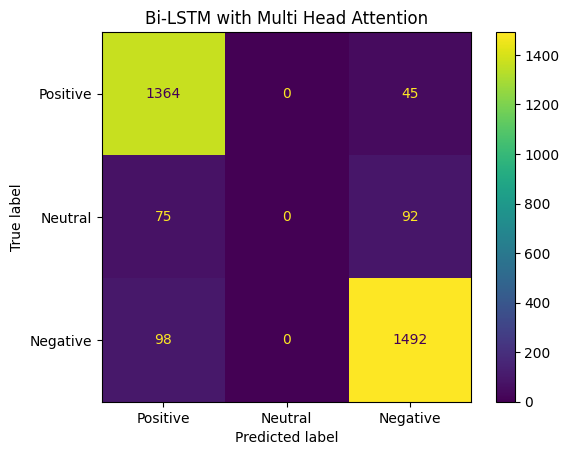

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Concatenate, GlobalMaxPooling1D, Dense, MultiHeadAttention
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report

def generate_model(data_vocab_size, embedding_matrix):
    dropout_threshold = 0.3  
    input_dim = data_vocab_size
    output_dim = 300  
    input_length = 130
    initializer = tf.keras.initializers.GlorotNormal()
    
    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, 
                        embeddings_initializer=initializer, weights=[embedding_matrix])(input_layer)

    feature = Dropout(0.5)(feature)  
    # Convolutional Path
    cnn_feature = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu')(feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 128
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Recurrent Path

    bi_lstm_feature = Bidirectional(LSTM(units=300, dropout=0.2, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    
    # Self-Attention Layer
    attention_output = MultiHeadAttention(num_heads=12, key_dim=32)(bi_lstm_feature, bi_lstm_feature)
    attention_output = LayerNormalization()(attention_output)
    attention_output = Dropout(dropout_threshold)(attention_output)  # Increased dropout rate
    # Apply GlobalMaxPooling1D to both feature maps
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature)         
    attention_pooled = GlobalMaxPooling1D()(attention_output)  

    # Concatenate the pooled features
    combine_feature = Concatenate()([cnn_pooled, attention_pooled])
    combine_feature = LayerNormalization()(combine_feature)
    combine_feature = Dropout(dropout_threshold)(combine_feature)  
    
    # Classification Layers
    classifier = Dense(256, activation='relu')(combine_feature)  
    classifier = Dropout(dropout_threshold)(classifier)  
    classifier = Dense(64, activation='relu')(classifier)  
    classifier = Dropout(dropout_threshold)(classifier)  
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

model_cnn_l = generate_model(10000, embedding_matrix)
adam = Adam(learning_rate=1e-4, weight_decay=0.0)
model_cnn_l.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history_cnn = model_cnn_l.fit(
    x=test_features,
    y=y_test,
    validation_data=(dev_features, y_dev),
    epochs=500,
    batch_size=64,
    callbacks=[early_stopping]
)
label_class = ['Positive', 'Neutral', 'Negative']
model_cnn_l.evaluate(test_features, y_test)
preds = model_cnn_l.predict(test_features)
preds = tf.round(preds).numpy()
print(classification_report(y_test, preds, target_names=label_class, zero_division=0))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('Bi-LSTM with Multi Head Attention')

In [ ]:
model_cnn_l.save('model_cnn_l.keras')
model_cnn_l.load_weights("model_cnn_l.keras")
model_cnn_l.evaluate(test_features, y_test)

from sklearn.metrics import classification_report
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']
model_cnn_l.load_weights('/kaggle/working/model_cnn_l.keras')
model_cnn_l.evaluate(test_features, y_test)

preds = model_cnn_l.predict(test_features)
preds = tf.round(preds).numpy()

print(classification_report(y_test, preds, target_names=label_class, zero_division=0))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('Bi-LSTM with Multi Head Attention')

In [ ]:
!pip install tf-models-official

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import SpatialDropout1D, Input, Embedding, Conv1D, MaxPool1D, Dropout, BatchNormalization, GlobalMaxPooling1D, Dense, Bidirectional, LSTM, LayerNormalization, MultiHeadAttention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow_models as tfm 

def build_model(hp):
    input_dim = data_vocab_size  
    output_dim = 300
    input_length = 110
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, 
                        embeddings_initializer=initializer, weights=[embedding_matrix])(input_layer)
    feature = SpatialDropout1D(rate=hp.Float('features_dropout', min_value=0.0, max_value=0.6, step=0.1))(feature)
    

    cnn_feature_dropout = hp.Float('cnn_feature_dropout', min_value=0.0, max_value=0.6, step=0.1)
    # Convolutional Path
    cnn_feature1 = Conv1D(filters=hp.Int('filters_1', min_value=64, max_value=256, step=64), 
                          kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature1 = MaxPool1D()(cnn_feature1)
    cnn_feature1 = LayerNormalization()(cnn_feature1)
    cnn_feature1 = Dropout(cnn_feature_dropout)(cnn_feature1)
    cnn_feature2 = Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=256, step=64), 
                          kernel_size=5, padding='same', activation='relu')(cnn_feature1)
    cnn_feature2 = MaxPool1D()(cnn_feature2)
    cnn_feature2 = LayerNormalization()(cnn_feature2)
    cnn_feature2 = Dropout(cnn_feature_dropout)(cnn_feature2)
    cnn_feature3 = Conv1D(filters=hp.Int('filters_3', min_value=128, max_value=512, step=128), 
                          kernel_size=7, padding='same', activation='relu')(cnn_feature2)
    cnn_feature3 = MaxPool1D()(cnn_feature3)
    cnn_feature3 = LayerNormalization()(cnn_feature3)
    cnn_feature3 = Dropout(cnn_feature_dropout)(cnn_feature3)
    cnn_feature4 = Conv1D(filters=hp.Int('filters_4', min_value=128, max_value=512, step=128), 
                          kernel_size=9, padding='same', activation='relu')(cnn_feature3)
    cnn_feature4 = MaxPool1D()(cnn_feature4)
    cnn_feature4 = LayerNormalization()(cnn_feature4)
    cnn_feature4 = Dropout(cnn_feature_dropout)(cnn_feature4)
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature4)
    cnn_pooled_dropout = hp.Float('cnn_pooled_dropout', min_value=0.0, max_value=0.6, step=0.1)
    cnn_pooled = Dropout(cnn_pooled_dropout)(cnn_pooled)

    bi_lstm_feature_dropout = hp.Float('bi_lstm_feature_dropout', min_value=0.0, max_value=0.6, step=0.1)
    # LSTM Path
    bi_lstm_feature = Bidirectional(LSTM(units=hp.Int('lstm_units_1', min_value=128, max_value=512, step=128), 
                                         dropout=bi_lstm_feature_dropout, return_sequences=True, kernel_initializer=initializer))(cnn_feature4)
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    bi_lstm_feature = Dropout(bi_lstm_feature_dropout)(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(LSTM(units=hp.Int('lstm_units_2', min_value=128, max_value=512, step=128), 
                                         dropout=bi_lstm_feature_dropout, return_sequences=True, kernel_initializer=initializer))(bi_lstm_feature)
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature)
    bi_lstm_pooled = GlobalMaxPooling1D()(bi_lstm_feature)
    bi_lstm_pooled = LayerNormalization()(bi_lstm_pooled)
    bi_lstm_pooled_dropout = hp.Float('bi_lstm_pooled_dropout', min_value=0.0, max_value=0.6, step=0.1)
    bi_lstm_pooled = Dropout(bi_lstm_pooled_dropout)(bi_lstm_pooled)
    
    # Attention Path
    attention_output = MultiHeadAttention(num_heads=hp.Int('num_heads', min_value=4, max_value=12, step=4), 
                                          key_dim=hp.Int('key_dim', min_value=4, max_value=64, step=4))(bi_lstm_feature, bi_lstm_feature)
    attention_pooled = GlobalMaxPooling1D()(attention_output)
    attention_pooled = LayerNormalization()(attention_pooled)
    attention_pooled_dropout = hp.Float('attention_pooled_dropout', min_value=0.0, max_value=0.6, step=0.1)
    attention_pooled = Dropout(attention_pooled_dropout)(attention_pooled)

    # attention_combine_layer = MultiHeadAttention(num_heads=4, key_dim=64)
    # attention_output = attention_combine_layer(query=bi_lstm_pooled, key=attention_pooled, value=cnn_pooled)
    # combine_feature = Concatenate()([attention_output, bi_lstm_pooled, cnn_pooled])
    
    # Combine Features
    combine_feature = Concatenate()([bi_lstm_pooled, attention_pooled, cnn_pooled])
    combine_feature = LayerNormalization()(combine_feature)
    combine_feature_dropout = hp.Float('combine_feature_dropout', min_value=0.0, max_value=0.6, step=0.1)
    combine_feature = Dropout(combine_feature_dropout)(combine_feature)

    classifier_dropout = hp.Float('classifier_dropout', min_value=0.0, max_value=0.6, step=0.1)
    # Dense Layers
    classifier = Dense(units=hp.Int('dense_units_1', min_value=128, max_value=512, step=128), activation='relu')(combine_feature)
    classifier = Dropout(classifier_dropout)(classifier)
    classifier = Dense(units=hp.Int('dense_units_2', min_value=64, max_value=256, step=64), activation='relu')(classifier)
    classifier = Dropout(classifier_dropout)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)

    # Compile the model
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 4e-4, 1e-5, 4e-5])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
!rm -rf /kaggle/working/my_tuning_dir_1

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_tuning_dir_1',
    project_name='cnn_lstm_attention_tuning'
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Tạo callback ModelCheckpoint 
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.weights.h5',    # Tên file bạn muốn lưu #không cho xài keras
    monitor='val_accuracy',      # Metric để theo dõi
    mode='max',                  # Lựa chọn "max" vì ta muốn val_accuracy lớn nhất
    save_best_only=True,         # Chỉ lưu lại model tốt nhất
    save_weights_only=True,      # Chỉ lưu trọng số (không cần lưu cấu trúc)
    verbose=1
)

# tuner.search(
#     x=train_features,
#     y=y_train,
#     validation_data=(dev_features, y_dev),
#     epochs=50,
#     batch_size=64,
#     callbacks=[EarlyStopping(monitor='val_accuracy', patience=8)]
# )

tuner.search(
    x=train_features,
    y=y_train,
    validation_data=(dev_features, y_dev),
    epochs=50,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=8),
               checkpoint_callback]  # Thêm callback này
)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

In [ ]:
history = best_model.fit(
    x=train_features,
    y=y_train,
    validation_data=(dev_features, y_dev),
    epochs=500,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)]
)

In [ ]:
from datetime import datetime

# Lấy ngày tháng năm hiện tại
now = datetime.now()
date_string= now.strftime("%d-%m-%Y")  # Định dạng: ngày-tháng-năm

best_model.save('model_multi_cnn_multi_lstm_multihead_attention_fined_tuned.keras')
best_model.load_weights("model_multi_cnn_multi_lstm_multihead_attention_fined_tuned.keras")
best_model.evaluate(test_features, y_test)

from sklearn.metrics import classification_report
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']
best_model.load_weights('/kaggle/working/model_multi_cnn_multi_lstm_multihead_attention_fined_tuned.keras')
best_model.evaluate(test_features, y_test)

preds = best_model.predict(test_features)
preds = tf.round(preds).numpy()

print(classification_report(y_test, preds, target_names=label_class, zero_division=0))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']


y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('Multi CNN Bi-LSTM')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, Conv2D, MaxPool1D, MaxPooling2D, Dropout, 
    BatchNormalization, GlobalMaxPooling1D, GlobalMaxPooling2D, Dense, 
    Bidirectional, LSTM, LayerNormalization, MultiHeadAttention, Concatenate, Reshape
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def generate_model_with_conv2d(data_vocab_size, embedding_matrix=None):
    dropout_threshold = 0.1  
    input_dim = data_vocab_size
    output_dim = 300  
    input_length = 110
    initializer = tf.keras.initializers.GlorotNormal()
    
    input_layer = Input(shape=(input_length,))
    
    # Embedding Layer
    if embedding_matrix is not None:
        feature = Embedding(
            input_dim=input_dim, 
            output_dim=output_dim, 
            embeddings_initializer=initializer, 
            weights=[embedding_matrix],
            input_length=input_length,
            trainable=False  # Set to True if you want to fine-tune embeddings
        )(input_layer)
    else:
        feature = Embedding(
            input_dim=input_dim, 
            output_dim=output_dim, 
            embeddings_initializer=initializer,
            input_length=input_length
        )(input_layer)
    
    feature = Dropout(0.5)(feature)  
    
    ### Conv1D Path ###
    cnn_feature1 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature1 = MaxPool1D()(cnn_feature1)
    cnn_feature1 = BatchNormalization()(cnn_feature1)
    cnn_feature1 = Dropout(dropout_threshold)(cnn_feature1)

    cnn_feature2 = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(cnn_feature1)
    cnn_feature2 = MaxPool1D()(cnn_feature2)
    cnn_feature2 = BatchNormalization()(cnn_feature2)
    cnn_feature2 = Dropout(dropout_threshold)(cnn_feature2)

    cnn_feature3 = Conv1D(filters=256, kernel_size=7, padding='same', activation='relu')(cnn_feature2)
    cnn_feature3 = MaxPool1D()(cnn_feature3)
    cnn_feature3 = BatchNormalization()(cnn_feature3)
    cnn_feature3 = Dropout(dropout_threshold)(cnn_feature3)

    cnn_feature4 = Conv1D(filters=256, kernel_size=9, padding='same', activation='relu')(cnn_feature3)
    cnn_feature4 = MaxPool1D()(cnn_feature4)
    cnn_feature4 = BatchNormalization()(cnn_feature4)
    cnn_feature4 = Dropout(dropout_threshold)(cnn_feature4)

    cnn_pooled = GlobalMaxPooling1D()(cnn_feature4)

    ### Bi-LSTM and Attention Path ###
    bi_lstm_feature = Bidirectional(LSTM(units=300, dropout=0.2, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature4)
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(LSTM(units=128, dropout=0.2, return_sequences=True,
                                         kernel_initializer=initializer))(bi_lstm_feature)
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    bi_lstm_pooled = GlobalMaxPooling1D()(bi_lstm_feature)
    bi_lstm_pooled = Dropout(dropout_threshold)(bi_lstm_pooled)

    attention_output = MultiHeadAttention(num_heads=12, key_dim=32)(bi_lstm_feature, bi_lstm_feature)
    attention_output = LayerNormalization()(attention_output)
    attention_pooled = GlobalMaxPooling1D()(attention_output)  
    attention_pooled = Dropout(dropout_threshold)(attention_pooled)

    ### Conv2D Path ###
    # Reshape for Conv2D: (batch_size, height, width, channels)
    conv2d_input = Reshape((input_length, output_dim, 1))(feature)  # (batch_size, 110, 300, 1)

    conv2d_layer1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(conv2d_input)
    conv2d_layer1 = MaxPooling2D(pool_size=(2,2))(conv2d_layer1)
    conv2d_layer1 = BatchNormalization()(conv2d_layer1)
    conv2d_layer1 = Dropout(dropout_threshold)(conv2d_layer1)

    conv2d_layer2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv2d_layer1)
    conv2d_layer2 = MaxPooling2D(pool_size=(2,2))(conv2d_layer2)
    conv2d_layer2 = BatchNormalization()(conv2d_layer2)
    conv2d_pooled = GlobalMaxPooling2D()(conv2d_layer2)  # (batch_size, features)
    conv2d_layer2 = Dropout(dropout_threshold)(conv2d_pooled)

    ### Combine All Features ###
    combine_feature = Concatenate()([bi_lstm_pooled, attention_pooled, cnn_pooled, conv2d_pooled])
    combine_feature = LayerNormalization()(combine_feature)
    combine_feature = Dropout(dropout_threshold)(combine_feature)

    # Dense layers with L2 regularization (optional)
    classifier = Dense(256, activation='relu')(classifier)
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(64, activation='relu')(classifier)
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)  # Final output layer

    model = Model(inputs=input_layer, outputs=classifier)
    return model

# Example usage:
# data_vocab_size = 3636  # Replace with your actual vocab size
# embedding_matrix = ...    # Define or load your embedding matrix if available
model_cnn = generate_model_with_conv2d(data_vocab_size, embedding_matrix=embedding_matrix)

adam = Adam(learning_rate=1e-4)
model_cnn.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=500, restore_best_weights=True)

history_cnn = model_cnn.fit(
    x=train_features,
    y=y_train,
    validation_data=(dev_features, y_dev),
    epochs=500,
    batch_size=64,
    callbacks=[early_stopping]
)


In [ ]:
from datetime import datetime

# Lấy ngày tháng năm hiện tại
now = datetime.now()
date_string= now.strftime("%d-%m-%Y")  # Định dạng: ngày-tháng-năm

# model_cnn.save('model_multi_cnn2d_multi_lstm_multihead_attention.keras')
# model_cnn.load_weights("model_multi_cnn2d_multi_lstm_multihead_attention.keras")
model_cnn.evaluate(test_features, y_test)

from sklearn.metrics import classification_report
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']
# model_cnn.load_weights('/kaggle/working/model_multi_cnn2d_multi_lstm_multihead_attention.keras')
model_cnn.evaluate(test_features, y_test)

preds = model_cnn.predict(test_features)
preds = tf.round(preds).numpy()

print(classification_report(y_test, preds, target_names=label_class, zero_division=0))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']


y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('Bi-LSTM')

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPool1D, Dropout, 
    BatchNormalization, GlobalMaxPooling1D, Bidirectional, LSTM, 
    LayerNormalization, MultiHeadAttention, Concatenate, Reshape, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def generate_model_with_tuner(hp):
    dropout_threshold = hp.Float('dropout_threshold', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
    input_dim = data_vocab_size
    output_dim = 300
    input_length = 110
    initializer = tf.keras.initializers.GlorotNormal()
    
    input_layer = Input(shape=(input_length,))
    
    # Embedding Layer
    if embedding_matrix is not None:
        feature = Embedding(
            input_dim=input_dim, 
            output_dim=output_dim, 
            embeddings_initializer=initializer, 
            weights=[embedding_matrix],
            input_length=input_length,
            trainable=False
        )(input_layer)
    else:
        feature = Embedding(
            input_dim=input_dim, 
            output_dim=output_dim, 
            embeddings_initializer=initializer,
            input_length=input_length
        )(input_layer)
    
    feature = Dropout(dropout_threshold)(feature)  
    
    ### Conv1D Path ###
    filters_1 = hp.Int('filters_1', min_value=64, max_value=256, step=64, default=128)
    filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64, default=128)
    filters_3 = hp.Int('filters_3', min_value=128, max_value=512, step=128, default=256)

    cnn_feature1 = Conv1D(filters=filters_1, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature1 = MaxPool1D()(cnn_feature1)
    cnn_feature1 = BatchNormalization()(cnn_feature1)
    cnn_feature1 = Dropout(dropout_threshold)(cnn_feature1)

    cnn_feature2 = Conv1D(filters=filters_2, kernel_size=5, padding='same', activation='relu')(cnn_feature1)
    cnn_feature2 = MaxPool1D()(cnn_feature2)
    cnn_feature2 = BatchNormalization()(cnn_feature2)
    cnn_feature2 = Dropout(dropout_threshold)(cnn_feature2)

    cnn_feature3 = Conv1D(filters=filters_3, kernel_size=7, padding='same', activation='relu')(cnn_feature2)
    cnn_feature3 = MaxPool1D()(cnn_feature3)
    cnn_feature3 = BatchNormalization()(cnn_feature3)
    cnn_feature3 = Dropout(dropout_threshold)(cnn_feature3)

    cnn_pooled = GlobalMaxPooling1D()(cnn_feature3)

    ### Bi-LSTM and Attention Path ###
    bi_lstm_units_1 = hp.Int('bi_lstm_units_1', min_value=128, max_value=512, step=128, default=300)
    bi_lstm_units_2 = hp.Int('bi_lstm_units_2', min_value=64, max_value=256, step=64, default=128)
    
    bi_lstm_feature = Bidirectional(LSTM(units=bi_lstm_units_1, dropout=0.2, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature3)
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(LSTM(units=bi_lstm_units_2, dropout=0.2, return_sequences=True,
                                         kernel_initializer=initializer))(bi_lstm_feature)
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    bi_lstm_pooled = GlobalMaxPooling1D()(bi_lstm_feature)
    bi_lstm_pooled = Dropout(dropout_threshold)(bi_lstm_pooled)

    attention_output = MultiHeadAttention(num_heads=12, key_dim=32)(bi_lstm_feature, bi_lstm_feature)
    attention_output = LayerNormalization()(attention_output)
    attention_pooled = GlobalMaxPooling1D()(attention_output)  
    attention_pooled = Dropout(dropout_threshold)(attention_pooled)

    ### Conv2D Path ###
    conv2d_filters_1 = hp.Int('conv2d_filters_1', min_value=16, max_value=64, step=16, default=32)
    conv2d_filters_2 = hp.Int('conv2d_filters_2', min_value=32, max_value=128, step=32, default=64)
    
    conv2d_input = Reshape((input_length, output_dim, 1))(feature)

    conv2d_layer1 = Conv2D(filters=conv2d_filters_1, kernel_size=(3,3), activation='relu', padding='same')(conv2d_input)
    conv2d_layer1 = MaxPooling2D(pool_size=(2,2))(conv2d_layer1)
    conv2d_layer1 = BatchNormalization()(conv2d_layer1)
    conv2d_layer1 = Dropout(dropout_threshold)(conv2d_layer1)

    conv2d_layer2 = Conv2D(filters=conv2d_filters_2, kernel_size=(3,3), activation='relu', padding='same')(conv2d_layer1)
    conv2d_layer2 = MaxPooling2D(pool_size=(2,2))(conv2d_layer2)
    conv2d_layer2 = BatchNormalization()(conv2d_layer2)
    conv2d_pooled = GlobalMaxPooling2D()(conv2d_layer2)  
    conv2d_layer2 = Dropout(dropout_threshold)(conv2d_pooled)

    ### Combine All Features ###
    combine_feature = Concatenate()([bi_lstm_pooled, attention_pooled, cnn_pooled, conv2d_pooled])
    combine_feature = LayerNormalization()(combine_feature)
    combine_feature = Dropout(dropout_threshold)(combine_feature)

    # Dense layers with L2 regularization (optional)
    dense_units_1 = hp.Int('dense_units_1', min_value=128, max_value=512, step=128, default=256)
    dense_units_2 = hp.Int('dense_units_2', min_value=64, max_value=256, step=64, default=64)
    
    classifier = Dense(dense_units_1, activation='relu')(combine_feature)
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(dense_units_2, activation='relu')(classifier)
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)  # Final output layer

    model = Model(inputs=input_layer, outputs=classifier)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Xác định Hyperparameters
tuner = kt.Hyperband(
    generate_model_with_tuner,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='conv2d_lstm_attention',
    project_name='conv2d_lstm_attention'
)

# Tuning model
tuner.search(
    x=train_features,
    y=y_train,
    validation_data=(dev_features, y_dev),
    epochs=50,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=8)]  # Thêm callback này
)

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Compile lại mô hình tốt nhất


# Huấn luyện mô hình với early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history_cnn = best_model.fit(
    train_features,
    y_train,
    validation_data=(dev_features, y_dev),
    epochs=500,
    batch_size=64,
    callbacks=[early_stopping]
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization,
    Bidirectional, LSTM, Concatenate, GlobalMaxPooling1D, Dense, MultiHeadAttention
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW

def generate_model_1(data_vocab_size, embedding_matrix):
    dropout_threshold = 0.1  
    input_dim = data_vocab_size
    output_dim = 300  
    input_length = 150
    initializer = tf.keras.initializers.GlorotNormal()
    
    input_layer = Input(shape=(input_length,), name='input_layer')
    
    # Embedding Layer
    embedding = Embedding(
        input_dim=input_dim,
        output_dim=output_dim, 
        embeddings_initializer=initializer,
        weights=[embedding_matrix],
        trainable=True,
        name='embedding_layer'
    )(input_layer)

    # Recurrent Path (LSTM) - Moved Before CNN
    bi_lstm_feature = Bidirectional(
        LSTM(
            units=300, 
            dropout=dropout_threshold, 
            return_sequences=True,
            kernel_initializer=initializer
        ),
        name='bidirectional_lstm'
    )(embedding)
    bi_lstm_feature = MaxPool1D(name='maxpool1d_lstm')(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization(name='layernorm_lstm')(bi_lstm_feature)
    
    # Convolutional Path (CNN) - Now After LSTM
    cnn_feature = Conv1D(
        filters=128, 
        kernel_size=3, 
        padding='valid', 
        activation='relu',
        name='conv1d'
    )(bi_lstm_feature)  # Changed input from 'feature' to 'bi_lstm_feature'
    cnn_feature = MaxPool1D(name='maxpool1d_cnn')(cnn_feature)
    cnn_feature = Dropout(dropout_threshold, name='dropout_cnn')(cnn_feature)
    cnn_feature = LayerNormalization(name='layernorm_cnn')(cnn_feature)
    
    # Self-Attention Layer
    attention_output = MultiHeadAttention(
        num_heads=12, 
        key_dim=32, 
        name='multihead_attention'
    )(cnn_feature, cnn_feature)
    attention_output = LayerNormalization(name='layernorm_attention')(attention_output)
    attention_output = Dropout(dropout_threshold, name='dropout_attention')(attention_output)
    
    # Global Max Pooling
    cnn_pooled = GlobalMaxPooling1D(name='globalmaxpool_cnn')(cnn_feature)         
    attention_pooled = GlobalMaxPooling1D(name='globalmaxpool_attention')(attention_output)  

    # Concatenate Features
    combined = Concatenate(name='concatenate')([cnn_pooled, attention_pooled])
    combined = LayerNormalization(name='layernorm_combined')(combined)
    combined = Dropout(dropout_threshold, name='dropout_combined')(combined)  
    
    # Classification Layers
    dense = Dense(256, activation='relu', name='dense_1')(combined)  
    dense = Dropout(dropout_threshold, name='dropout_dense_1')(dense)
    output = Dense(3, activation='sigmoid', name='output_layer')(dense)

    # Define the Model
    model = Model(inputs=input_layer, outputs=output, name='rearranged_model')
    return model

# Example usage:
# data_vocab_size = 2155  # Replace with your actual vocab size
# embedding_matrix = your_embedding_matrix  # Replace with your actual embedding matrix
model = generate_model_1(data_vocab_size, embedding_matrix)

adamw = AdamW(learning_rate=4e-4, weight_decay=0.0)
model.compile(optimizer=adamw, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Concatenate, GlobalMaxPooling1D, Dense, MultiHeadAttention, Attention

def generate_model_luong_attention(data_vocab_size):
    dropout_threshold = 0.1
    input_dim = data_vocab_size
    output_dim = 300  
    input_length = 256
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, 
                        embeddings_initializer=initializer)(input_layer)

    # Convolutional Path
    cnn_feature = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 128
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(cnn_feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 64
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Recurrent Path
    bi_lstm_feature = Bidirectional(LSTM(units=64, dropout=dropout_threshold, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Self-Attention Layer
    attention_output = Attention(use_scale=True, score_mode='dot', dropout=0.1)([bi_lstm_feature, bi_lstm_feature]) #Luong-Style
    attention_output = LayerNormalization()(attention_output)
    attention_output = Dropout(dropout_threshold)(attention_output)

    # Apply GlobalMaxPooling1D to both feature maps
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature)         
    attention_pooled = GlobalMaxPooling1D()(attention_output)  

    # Concatenate the pooled features
    combine_feature = Concatenate()([cnn_pooled, attention_pooled])
    combine_feature = LayerNormalization()(combine_feature)
    combine_feature = Dropout(dropout_threshold)(combine_feature)  
    
    # Classification Layers
    classifier = Dense(128, activation='relu')(combine_feature)  
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(64, activation='relu')(classifier)  
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

# Example usage:
model = generate_model_luong_attention(data_vocab_size)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Concatenate, GlobalMaxPooling1D, Dense, MultiHeadAttention
from tensorflow.keras.optimizers import AdamW

def generate_model_querygroup_attention(data_vocab_size):
    dropout_threshold = 0.3 
    input_dim = data_vocab_size
    output_dim = 100  
    input_length = 150
    initializer = tf.keras.initializers.LecunNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, 
                        embeddings_initializer=initializer)(input_layer)

    # Convolutional Path
    cnn_feature = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 128
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(cnn_feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 64
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

        # Recurrent Path
    bi_lstm_feature = Bidirectional(LSTM(units=64, dropout=dropout_threshold, return_sequences=True,
                                         kernel_initializer=initializer))(cnn_feature)  # Increased units
    bi_lstm_feature = MaxPool1D()(bi_lstm_feature) 
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)
    

    attention_layer = tf.keras.layers.GroupQueryAttention(
        head_dim=64, 
        num_query_heads=8, 
        num_key_value_heads=8, 
        dropout=0.2
    )
    # Self-Attention Layer
    attention_output = attention_layer(bi_lstm_feature, bi_lstm_feature) #Luong-Style
    attention_output = LayerNormalization()(attention_output)
    attention_output = Dropout(dropout_threshold)(attention_output)

    # Apply GlobalMaxPooling1D to both feature maps
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature)         
    attention_pooled = GlobalMaxPooling1D()(attention_output)  

    # Concatenate the pooled features
    combine_feature = Concatenate()([cnn_pooled, attention_pooled])
    combine_feature = LayerNormalization()(combine_feature)
    combine_feature = Dropout(dropout_threshold)(combine_feature)  
    
    # Classification Layers
    classifier = Dense(128, activation='relu')(combine_feature)  
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(64, activation='relu')(classifier)  
    classifier = Dropout(dropout_threshold)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

# Example usage:
data_vocab_size = 3814  # Replace with your actual vocab size
model = generate_model_querygroup_attention(data_vocab_size)
adamw = AdamW(learning_rate=4e-4, weight_decay=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# dot_img_file = 'model_visualize.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
# # Detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # Instantiate a distribution strategy
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     model = generate_model(data_vocab_size)
#     model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# history = model.fit(
#     x=X_train,
#     y=y_train,
#     validation_data=(X_val, y_val),
#     epochs=50,
#     batch_size=32,
#     callbacks=[early_stopping]
# )

In [ ]:
# Import necessary libraries
from imblearn.under_sampling import (
    ClusterCentroids,
    CondensedNearestNeighbour,
    RandomUnderSampler,
    NearMiss,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    InstanceHardnessThreshold,
    AllKNN,
    NeighbourhoodCleaningRule,
    OneSidedSelection,
    TomekLinks
)
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTEN,
    SMOTE,
    SMOTENC,
    ADASYN,
    BorderlineSMOTE,
    KMeansSMOTE,
    SVMSMOTE
)
from imblearn.combine import (
    SMOTEENN,
    SMOTETomek
)

# Initialize Under-Sampling Methods
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=2004), random_state=2004
)

cnn = CondensedNearestNeighbour(random_state=2004)  

rus = RandomUnderSampler(random_state=2004)

nearmiss = NearMiss()

enn = EditedNearestNeighbours()

renn = RepeatedEditedNearestNeighbours()

iht = InstanceHardnessThreshold(random_state=2004)

all_knn = AllKNN()

ncr = NeighbourhoodCleaningRule()

oss = OneSidedSelection(random_state=2004)

tl = TomekLinks()

# Initialize Over-Sampling Methods
ros = RandomOverSampler(random_state=1004)

smoten = SMOTEN(random_state=2004)

smote = SMOTE(sampling_strategy='auto', random_state=2004)

smotenc = SMOTENC(sampling_strategy='auto', random_state=2004, categorical_features=[...])  # Specify categorical feature indices

adasyn = ADASYN(random_state=2004)

sm = BorderlineSMOTE(random_state=2004)

kmean_smote = KMeansSMOTE(
    kmeans_estimator=MiniBatchKMeans(n_init=3, random_state=2004), random_state=2004
)

svm_smote = SVMSMOTE(random_state=2004)

# Initialize Combined Over and Under Sampling Methods
smoteen = SMOTEENN(random_state=2004)

smt = SMOTETomek(random_state=2004)

# Apply Under-Sampling Methods
X_resampled_cc, y_resampled_cc = cc.fit_resample(train_features, y_train)
X_resampled_cnn, y_resampled_cnn = cnn.fit_resample(train_features, y_train)
X_resampled_rus, y_resampled_rus = rus.fit_resample(train_features, y_train)
X_resampled_nearmiss, y_resampled_nearmiss = nearmiss.fit_resample(train_features, y_train)
X_resampled_enn, y_resampled_enn = enn.fit_resample(train_features, y_train)
X_resampled_renn, y_resampled_renn = renn.fit_resample(train_features, y_train)
X_resampled_iht, y_resampled_iht = iht.fit_resample(train_features, y_train)
X_resampled_all_knn, y_resampled_all_knn = all_knn.fit_resample(train_features, y_train)
X_resampled_ncr, y_resampled_ncr = ncr.fit_resample(train_features, y_train)
X_resampled_oss, y_resampled_oss = oss.fit_resample(train_features, y_train)
X_resampled_tl, y_resampled_tl = tl.fit_resample(train_features, y_train)



In [ ]:
# Apply Over-Sampling Methods
X_resampled_ros, y_resampled_ros = ros.fit_resample(train_features, y_train)
X_resampled_smoten, y_resampled_smoten = smoten.fit_resample(train_features, y_train)
X_resampled_smote, y_resampled_smote = smote.fit_resample(train_features, y_train)
# Note: For SMOTENC, specify the indices of categorical features
# Replace [...] with actual indices, e.g., [0, 2, 3]

X_resampled_sm, y_resampled_sm = sm.fit_resample(train_features, y_train)
X_resampled_svm_smote, y_resampled_svm_smote = svm_smote.fit_resample(train_features, y_train)

# Apply Combined Over and Under Sampling Methods
X_resampled_smoteen, y_resampled_smoteen = smoteen.fit_resample(train_features, y_train)
X_resampled_smt, y_resampled_smt = smt.fit_resample(train_features, y_train)

In [ ]:
ros = RandomOverSampler(random_state=3001)
X_resampled_ros, y_resampled_ros = ros.fit_resample(train_features, y_train)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early stopping callback
import tensorflow as tf

class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, decay_steps):
        super(WarmUp, self).__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

    def __call__(self, step):
        warmup_lr = self.initial_lr * (step / self.warmup_steps)
        decay_lr = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=self.initial_lr,
            decay_steps=self.decay_steps,
            decay_rate=0.96
        )(step - self.warmup_steps)
        return tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: decay_lr)

lr_schedule = WarmUp(initial_lr=1e-4, warmup_steps=500, decay_steps=10000)
adamw = AdamW(learning_rate=lr_schedule)


# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# history = model.fit(
#     x=X_resampled_smote,
#     y=y_resampled_smote,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )


early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
history = model.fit(
    x=train_features,
    y=y_train,
    validation_data=(dev_features, y_dev),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# history = model.fit(
#     x=X_resampled_ros,
#     y=y_resampled_ros,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# history = model.fit(
#     x=X_resampled_cc,
#     y=y_resampled_cc,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_cnn,
#     y=y_resampled_cnn,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# history = model.fit(
#     x=X_resampled_rus,
#     y=y_resampled_rus,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# history = model.fit(
#     x=X_resampled_smoteen,
#     y=y_resampled_smoteen,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# history = model.fit(
#     x=X_resampled_nearmiss,
#     y=y_resampled_nearmiss,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# history = model.fit(
#     x=X_resampled_enn,
#     y=y_resampled_enn,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# history = model.fit(
#     x=X_resampled_renn,
#     y=y_resampled_renn,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_iht,
#     y=y_resampled_iht,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_all_knn,
#     y=y_resampled_all_knn,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_ncr,
#     y=y_resampled_ncr,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_oss,
#     y=y_resampled_oss,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_tl,
#     y=y_resampled_tl,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_smoten,
#     y=y_resampled_smoten,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )


# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_sm,
#     y=y_resampled_sm,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_svm_smote,
#     y=y_resampled_svm_smote,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)



# early_stopping = EarlyStoppiSequentialng(monitor='val_accuracy', patience=10, restore_best_weights=True)

# history = model.fit(
#     x=X_resampled_smt,
#     y=y_resampled_smt,
#     validation_data=(dev_features, y_dev),
#     epochs=100,
#     batch_size=128,
#     callbacks=[early_stopping, warm_up]
# )

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


In [ ]:
model.save('model_cnn_bilstm_multihead_attention_clean_edition.keras')
model.load_weights("model_cnn_bilstm_multihead_attention_clean_edition.keras")
model.evaluate(test_features, y_test)

In [ ]:
from sklearn.metrics import classification_report
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']
model.load_weights('/kaggle/working/model_cnn_bilstm_multihead_attention_clean_edition.keras')
model.evaluate(test_features, y_test)

preds = model.predict(test_features)
preds = tf.round(preds).numpy()

print(classification_report(y_test, preds, target_names=label_class, zero_division=0))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']


y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('Bi-LSTM With Multi Head Attention')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, SimpleRNN, Concatenate, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

def generate_modelRNN(data_vocab_size):
    dropout_threshold = 0.3  # Reduced dropout
    input_dim = data_vocab_size
    output_dim = 64  # Increased embedding dimension
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, 
                        embeddings_initializer=initializer)(input_layer)

    # Convolutional Path
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 256
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn_feature)  # Increased filters
    cnn_feature = MaxPool1D()(cnn_feature)  # Reduces to 128
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Recurrent Path
    bi_rnn_feature = Bidirectional(SimpleRNN(units=64, dropout=dropout_threshold, return_sequences=True,
                                             kernel_initializer=initializer))(cnn_feature)  # Replaced LSTM with SimpleRNN
    bi_rnn_feature = MaxPool1D()(bi_rnn_feature)  # Reduces to 64
    bi_rnn_feature = LayerNormalization()(bi_rnn_feature)

    # Apply GlobalMaxPooling1D to both feature maps
    cnn_pooled = GlobalMaxPooling1D()(cnn_feature)          # (None, 64)
    bi_rnn_pooled = GlobalMaxPooling1D()(bi_rnn_feature)    # (None, 128)

    # Concatenate the pooled features
    combine_feature = Concatenate()([cnn_pooled, bi_rnn_pooled])  # (None, 192)
    combine_feature = LayerNormalization()(combine_feature)

    # Classification Layers
    classifier = Dense(128, activation='relu')(combine_feature)  # Increased units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(64, activation='relu')(classifier)  # Reduced units
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model


data_vocab_size = 3814 
modelRNN = generate_modelRNN(data_vocab_size)
adam = Adam(learning_rate=0.0001)
modelRNN.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
modelRNN.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = modelRNN.fit(
    x=train_features,
    y=y_train,
    validation_data=(dev_features, y_dev),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


modelRNN.save('model_cnn_biRnn.keras')

In [ ]:
modelRNN.load_weights("model_cnn_biRnn.keras")
modelRNN.evaluate(test_features, y_test)

In [ ]:
from sklearn.metrics import classification_report
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']
modelRNN.load_weights('model_cnn_biRnn.keras')
modelRNN.evaluate(test_features, y_test)

preds_RNN = modelRNN.predict(test_features)
preds_RNN = tf.round(preds).numpy()

print(classification_report(y_test, preds_RNN, target_names=label_class, zero_division=0))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label_class = ['Tiêu cực', 'Trung Lập', 'Tích cực']

y_test_single_label = np.argmax(y_test, axis=1)
preds_single_label_RNN = np.argmax(preds_RNN, axis=1)

cm = confusion_matrix(y_test_single_label, preds_single_label_RNN, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot()
plt.gca().grid(False)
plt.title('Bi-RNN')

In [ ]:
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print("Text preprocessed:", input_text_pre_accent)
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=512)
    return vec_data

def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {'Tiêu cực': 0, 'Trung lập': 1, 'Tích cực': 2}
    label = list(label_dict.keys())
    return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)
    result, conf = inference_model(input_model, model)
    return result, conf

my_model = generate_model(data_vocab_size)
my_model.load_weights("/kaggle/working/model_cnn_bilstm.keras")

with open("tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

print(prediction("Cô dạy rất tốt", my_tokenizer, my_model))